# Inverted Pendulum DQN - Grid Search

This script is an extension to the inverted pendulum DQN algorithm in inv_pend.ipynb. This scripts automates the grid search in a hyperparameter space to explore the best performance of DQN.





TODO
- [ ] Package functions related to the experiment in a `GridSearch` class
    - **Attributes:**
        - Hyperparameters - model arch, lr , buffer_size, min_replay_szie, target_update_freq, gamma, eps_start, eps_end, eps_decay, episode_train, and batch_size
        - The simulation environment
    - **Methods:** 
        - `create_directory()` - for storing the training results for each hyperparameter configuration
        - `eps_greedy_policy()` - for picking out an action given the observation
        - `DQN_train()` - for training a Q network from simulation

- [ ] Save the model (parameters and architecture) following training in the grid searchd

In [3]:
import random                       # To draw a random batch of samples form the replay buffer
import gymnasium as gym
import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run
import re                                               # For checking the latest trial #
from contextlib import redirect_stdout

from collections import deque       # replay buffer is a double ended queue that allows elements to be added either to the end or the start

# Setup

In [4]:
class QNet_MLP(nn.Module):
    ''' A QNetwork class that dynamically initialize an MLP Q Net'''
    def __init__(self,input_dim,output_dim,hidden_layer = [64,32]):
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for size in hidden_layer:
            self.layers.append(nn.Linear(self.input_dim, size))
            self.input_dim = size
        
        self.layers.append(nn.Linear(self.input_dim,self.output_dim))
    
    def forward(self, input_data):
        for layer in self.layers[:-1]:
            input_data = torch.relu(layer(input_data))
        return self.layers[-1](input_data)

In [5]:
def create_directory(model_id: int,
                     lr: float, 
                     gamma: float,
                     epsilon_decay: int,
                     batch_size: int, 
                     buffer_size: int,
                     target_update_freq: int):
    ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

    Parameters: 
    ------------
    (hyperparameters for differentiating between different directory)
    
    lr : float
        the learning rate to optimize the Q network
    gamma : float 
        the discount rate in Q learning
    epsilon_decay : integer
        the amount of episode over which the exploratory rate (epsilon) decays
    batch_size : integer
        number of experience drawn from replay buffer to train the behaviour network
    buffer_size : integer
        the number of samples in the replay buffer at a time
    target_udpate_freq : integer
        the amount of step count during the training process before updating the target Q net (loading the parameters of the behaviour net onto the target Q Net)
    

    Returns
    ------------
    name_codified : str
        the shortened name for the current experiment 
    hyperparameters_codified : str
        the shortened string of hyperparameter configuration
    OUTPUT_DIR : path
        the directory to which the training results and model (state_dict and architecture) will be saved
    '''
    timestamp = datetime.now().strftime("%y%m%d_%H%M")

    BASE_DIR = os.getcwd()
    RESULT_DIR = os.path.join(BASE_DIR, "inv_pend_results")
    os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

    # Find the trial # of the latest run
    existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
    run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
    trial_number = max(run_numbers,default=-1)+1

    # Create a folder for the run
    name_codified = f"run_{trial_number:05d}"
    OUTPUT_DIR = os.path.join(BASE_DIR,"inv_pend_results",name_codified)
    os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

    
    # Store the training configs in JSON file
    training_params = {
        'model_id': model_id,
        'lr': lr,
        'gamma': gamma,
        'epsilon_decay': epsilon_decay,
        'batch_size': batch_size,
        'buffer_size': buffer_size,
        'target_update_freq': target_update_freq
    }

    # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
    trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
    if os.path.exists(trial_to_param_path):
        with open(trial_to_param_path, "r") as f:
            data = json.load(f)
    else:
        data = {name_codified: []}

    hyperparam_codified = f"{timestamp}_{model_id}_{lr}_{gamma}_{epsilon_decay}_{batch_size}_{buffer_size}_{target_update_freq}"
    data[name_codified] = hyperparam_codified

    with open(trial_to_param_path, "w") as f:
        json.dump(data, f, indent=2)

    # Store training parameters in each run 
    param_path = os.path.join(OUTPUT_DIR, "param_config.json")
    with open(param_path, "w") as f:
        json.dump({"parameters": training_params}, f, indent=2)

    return name_codified, hyperparam_codified, OUTPUT_DIR

In [6]:
def eps_greedy_policy(env, obs, epsilon: float, q_network: QNet_MLP):
    ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()

    return action

In [ ]:
def policy_eval(env_test, q_network, n_episode_test = 500, seed = None):
    ''' Assess the average reward when following a q_network '''
    
    total_reward = 0
    for i in range(n_episode_test):
        obs,_ = env_test.reset(seed=seed)
        done = False
        eps_reward = 0

        while not done:                 # Step thorugh the episode
            action = eps_greedy_policy(env_test, obs, epsilon=0, q_network=q_network)
            next_obs, reward, term, trunc, _ = env_test.step(action)

            eps_reward += reward

            obs = next_obs
            done = term or trunc

        print(f"Validating episode {i+1:4d}/{n_episode_test:4d}   |   Reward {eps_reward} ",end="\r")
        total_reward += eps_reward
    print("\n")
    average_reward = total_reward / n_episode_test

    return average_reward
    

In [17]:
def DQN_train(env,
              q_network: QNet_MLP, target_net: QNet_MLP, optimizer, 
              replay_buffer,
              target_update_freq,
              gamma,
              eps_start, eps_end, eps_decay,
              episode_train,
              batch_size, 
              seed = 42):
    ''' Function to train a policy for a set of hyperparameters '''

    msg = "Training ended successfully"

    reward_history = np.zeros(episode_train)
    epsilon = eps_start
    step_count = 0
    episode = 0
    target_network_update_count = 0

    # Control of early stopping
    consecutive_pass_count = 0           # Number of consecutive episodes where performance exceeds a threshold
    CONSECUTIVE_PASS_LIMIT = 3          # No. of consecutive episodes with higher performance than reward limit
    EPISODE_REWARD_LIMIT = 450
    train_terminated = False
    

    performance_crit = False
    while not train_terminated:     # Experiment level - loop through episodes
        obs, _ = env.reset(seed=seed)
        eps_rewards = 0
    
        while True:                 # Episode level - loop through steps
            action = eps_greedy_policy(env, obs, epsilon, q_network)

            # Interact with the environment
            next_obs, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            replay_buffer.append((obs, action, reward, next_obs, done))
            obs = next_obs
            eps_rewards += reward
            step_count += 1

            # Train the Q-net using a batch of samples from the experience replay
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.FloatTensor(np.array(states))            # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                actions = torch.LongTensor(actions).unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(np.array(next_states))
                dones = torch.FloatTensor(dones).unsqueeze(1)
                
                # Compute targets using target network Q(s',a',w_i^-)
                with torch.no_grad():
                    target_q_values = target_net(next_states)       # Find a batch of Q(s',a',w_i^-) from the batch of next_states
                    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                    targets = rewards + gamma * max_target_q_values * (1 - dones)       # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states
            
                # Compute the current Q values for the actions taken Q(s,a,w_i)
                q_values = q_network(states).gather(1, actions)         # obtain the q_values associated to the actual action taken in each sample

                # Update the parameters of the behaviour q_network
                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Periodically update the target network by loading the weights from the behavior network
            if step_count % target_update_freq == 0:
                target_network_update_count += 1
                target_net.load_state_dict(q_network.state_dict())

            if done:        # End of a training episode
                break

        # Decay epsilon after an episode
        epsilon = max(eps_end, epsilon - (eps_start - eps_end)/eps_decay)

        reward_history[episode] = eps_rewards
        # print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
        # print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

        
        if episode % 10 == 0:                   # print progress periodically
            print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}", end = "\r")

        # Monitor the performance during training for signs of good performance
        if eps_rewards >= EPISODE_REWARD_LIMIT:
            consecutive_pass_count += 1
        else:
            consecutive_pass_count = 0
            
        # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
        if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
            performance_crit = True 
            msg = f"Early termination at episode {episode:5d} - desired performance reached"


        episode += 1

        # Checking for early training termination or truncation
        train_terminated = (episode >= episode_train) or (performance_crit)
    print("\n")
    return reward_history, msg


In [9]:
# Helper function for EMA filters and plotting data
def EMA_filter(reward: list, alpha):
    ''' Function that runs an exponential moving average filter along a datastream '''
    output = np.zeros(len(reward)+1)
    output[0] = reward[0]
    for idx, item in enumerate(reward):
        output[idx+1] = (1 - alpha) * output[idx] + alpha * item
    
    return output

def plot_reward_hist(reward_history: list, save_path = None, alpha = 0.1):
    ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
    n_episodes= len(reward_history)
    episodes = range(n_episodes)
    filtered_reward_hist = EMA_filter(reward_history, alpha)

    plt.figure(figsize=(20,6))
    plt.plot(episodes, reward_history[:n_episodes], color = "blue")
    plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red")
    plt.title('Total reward per episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(['Total reward','Filtered reward'])

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path,'reward_history.png'))
    plt.show()

In [10]:
%%script test --no-raise-error
# Test creating the Q network with dynamic hidden layer when specifying the list of hidden nodes

Q_net = QNet_MLP(obs_space,action_space,[64,32])
summary(Q_net, (obs_space,))

Couldn't find program: 'test'


# Parameter Set

In [11]:
model_registry = {
    'DQN_MLP_v0': {
        'class': QNet_MLP,
        'config': [64,32]
    },
    'DQN_MLP_v1': {
        'class': QNet_MLP,
        'config': [32,32]
    },
    'DQN_MLP_v2': {
        
        'class': QNet_MLP,
        'config': [32,16]
    },
    'DQN_MLP_v3': {
        'class': QNet_MLP,
        'config': [16,16]
    }
}

The block below is used for testing the model creation automation (Uncomment the first line to run the test)

In [12]:
%%script test --no-raise-error
for model in model_registry:
    Q_net = QNet_MLP(obs_space, action_space, model_registry[model]['config'])
    # print(model_registry[model]['config'])
    print(Q_net)

Couldn't find program: 'test'


In [13]:
# # Actual parameter grid
# param_grid = {
#     'MODEL': [model for model in model_registry],
#     'LR': [5e-4, 1e-3, 5e-3, 1e-2],
#     "BUFFER_SIZE": [1000, 5000, 10000],
#     "MIN_REPLAY_SIZE": [1000],
#     "TARGET_UPDATE_FREQ": [1000, 5000, 10000],

#     "GAMMA": [0.90, 0.95, 0.98],
#     "EPSILON_START": [1.0],
#     "EPSILON_END": [0.1],
#     "EPSILON_DECAY": [1000, 5000, 10000],

#     "EPISODE_TRAIN": [5000],                # training truncation criteria
#     "BATCH_SIZE": [32, 64, 128]
# }

# success_criteria = 450                      #


In [14]:
# Simplified param grid to test functionality
param_grid = {
    # 'MODEL': [model for model in model_registry],
    'MODEL': ['DQN_MLP_v0', 'DQN_MLP_v1'],
    'LR': [1e-3],
    "BUFFER_SIZE": [5000],
    "MIN_REPLAY_SIZE": [1000],
    "TARGET_UPDATE_FREQ": [1000],

    "GAMMA": [0.95],
    "EPSILON_START": [1.0],
    "EPSILON_END": [0.1],
    "EPSILON_DECAY": [5000],

    "EPISODE_TRAIN": [5000],                # training truncation criteria
    "BATCH_SIZE": [32]
}

success_criteria = 450                      #


# Grid Search

Using itertools to loop through each combination of hyperparameters

Trial 1/2 - model DQN_MLP_v0, lr=0.001, buffer=5000, target_freq=1000, gamma=0.95, eps_decay=5000, batch_size=32
Episode  2420: Total reward =  73.0, Epsilon = 0.564, Step count = 104139, Target update count = 104

Runtime - 60.080
Early termination at episode  2428 - desired performance reached
Performance improved to   91 units of rewards in episode     4
Performance improved to  154 units of rewards in episode   469
Performance improved to  177 units of rewards in episode  1733
Performance improved to  347 units of rewards in episode  1828
Performance improved to  500 units of rewards in episode  2428
Validating episode  499/ 500   |   Reward 315.0 

Validation average reward 315.00


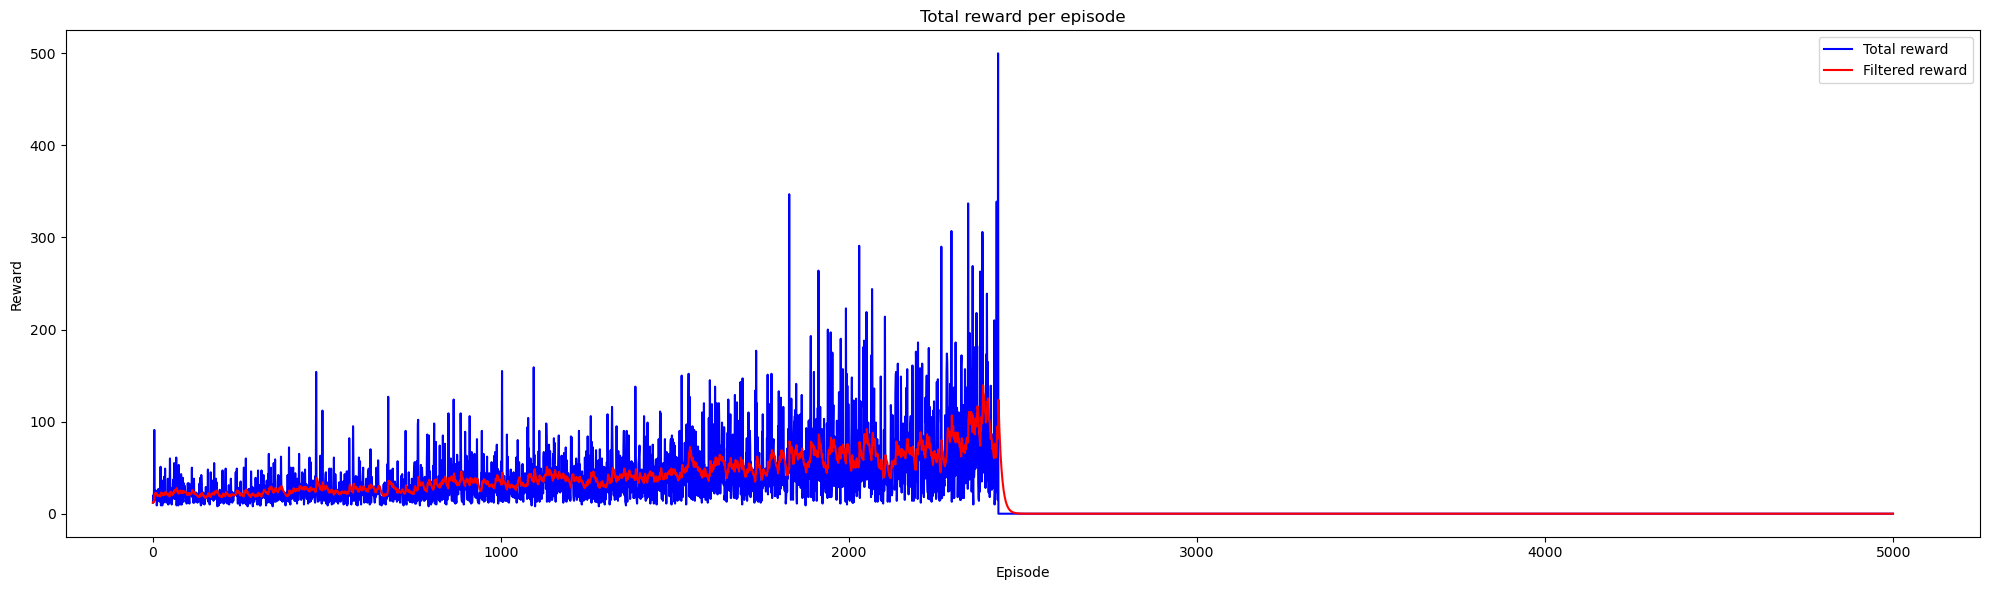

Trial 2/2 - model DQN_MLP_v1, lr=0.001, buffer=5000, target_freq=1000, gamma=0.95, eps_decay=5000, batch_size=32
Episode  4270: Total reward = 115.0, Epsilon = 0.231, Step count = 248249, Target update count = 248

Runtime - 140.669
Early termination at episode  4273 - desired performance reached
Performance improved to   75 units of rewards in episode     5
Performance improved to  119 units of rewards in episode   739
Performance improved to  136 units of rewards in episode  1108
Performance improved to  162 units of rewards in episode  1218
Performance improved to  186 units of rewards in episode  1418
Performance improved to  206 units of rewards in episode  1445
Performance improved to  227 units of rewards in episode  1786
Performance improved to  246 units of rewards in episode  1862
Performance improved to  268 units of rewards in episode  1922
Performance improved to  279 units of rewards in episode  1998
Performance improved to  314 units of rewards in episode  2517
Performan

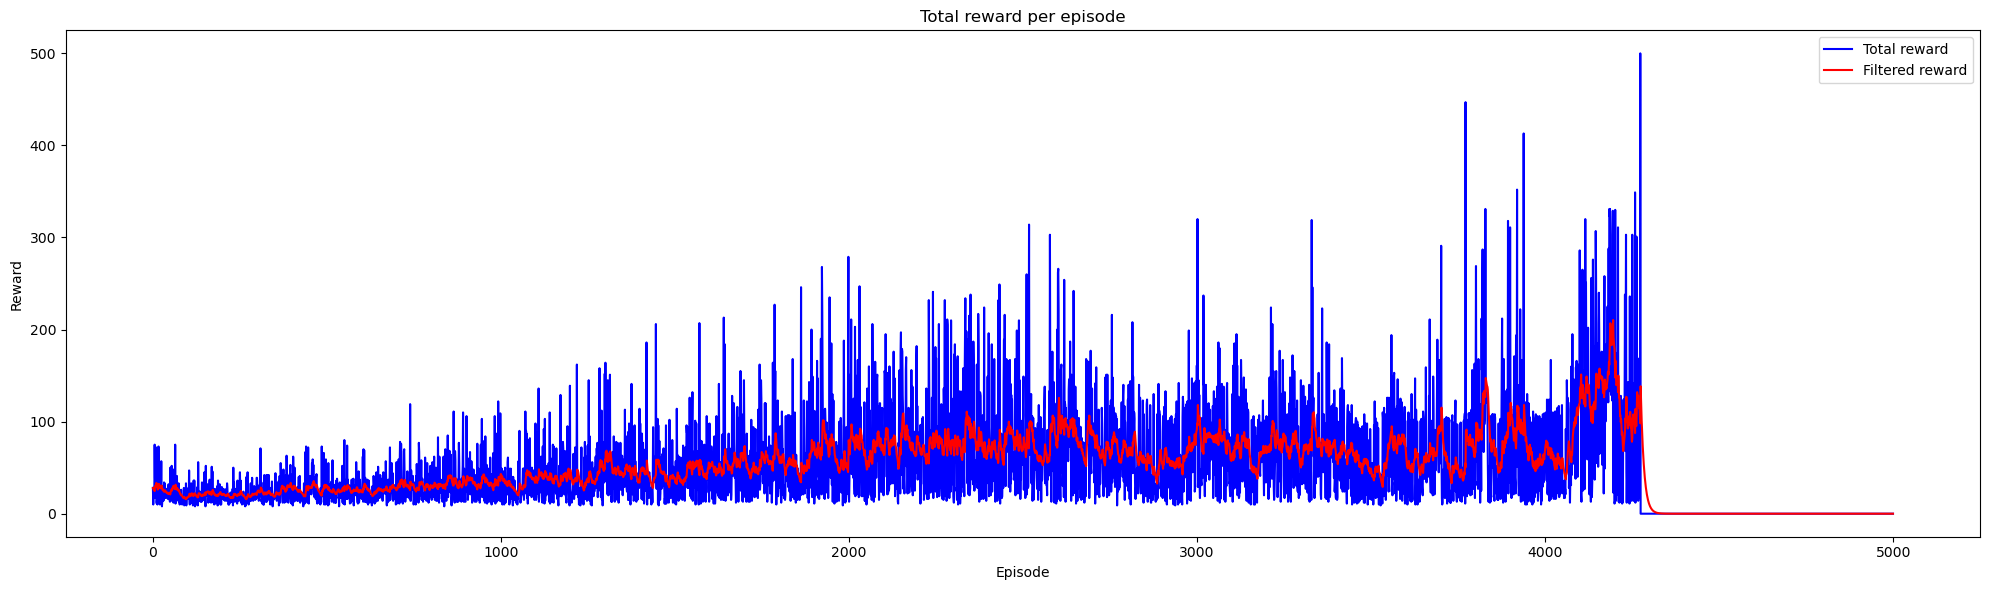

In [ ]:
import itertools
import time
keys, values = zip(*param_grid.items())
# keys, values = param_grid.keys(), param_grid.values()
num_config = len(list(itertools.product(*values)))

# Set fixed seed
seed = 42
np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

for idx, v in enumerate(itertools.product(*values)):

    # Unpacking the hyperparameter configurations
    config = dict(zip(keys,v))
    MODEL_NAME = config['MODEL']
    MODEL_CLASS = model_registry[config['MODEL']]['class']
    MODEL_CONFIG = model_registry[config['MODEL']]['config']
    match = re.search(r'v\d+',MODEL_NAME)
    MODEL_ID = match.group(0) if match else 404

    LR = config['LR']
    BUFFER_SIZE = config['BUFFER_SIZE']
    MIN_REPLAY_SIZE = config['MIN_REPLAY_SIZE']
    TARGET_UPDATE_FREQ = config['TARGET_UPDATE_FREQ']
    GAMMA = config['GAMMA']
    EPS_START = config['EPSILON_START']
    EPS_END = config['EPSILON_END']
    EPS_DECAY = config['EPSILON_DECAY']
    EPISODE_TRAIN = config['EPISODE_TRAIN']
    BATCH_SIZE = config['BATCH_SIZE']


    # Re-initialize the environment
    env = gym.make('CartPole-v1')
    obs,_ = env.reset(seed=seed)

    obs_space = env.observation_space.shape[0]
    action_space = env.action_space.n


    # Re-initialize the NN models
    Q_net = MODEL_CLASS(obs_space,action_space,MODEL_CONFIG)
    target_net = MODEL_CLASS(obs_space,action_space,MODEL_CONFIG)
    target_net.load_state_dict(Q_net.state_dict())
    target_net.eval()

    optimizer = optim.SGD(Q_net.parameters(), lr = LR)
    # optimizer = optim.Adam(Q_net.parameters(), lr = LR)

    # Re-initialize and pre-fill the replay buffer
    replay_buffer = deque(maxlen = BUFFER_SIZE)
    
    obs, _ = env.reset()
    for _ in range(MIN_REPLAY_SIZE):
        action = env.action_space.sample()
        next_obs, reward, term, trunc, _ = env.step(action)
        done = term or trunc

        replay_buffer.append((obs, action, reward, next_obs, done))
        obs = next_obs if not done else env.reset()[0]

    # Create the directory to store results
    _, _, save_path = create_directory(MODEL_ID,LR,GAMMA,EPS_DECAY,BATCH_SIZE,BUFFER_SIZE,TARGET_UPDATE_FREQ)

    # Training information
    print(f'Trial {idx+1}/{num_config} - model {MODEL_NAME}, lr={LR}, buffer={BUFFER_SIZE}, target_freq={TARGET_UPDATE_FREQ}, gamma={GAMMA}, eps_decay={EPS_DECAY}, batch_size={BATCH_SIZE}')
    
    # Train the DQN with the given hyperparameter configuration
    start_time = time.time()
    reward_history, msg = DQN_train(env, Q_net, target_net,optimizer,replay_buffer,
                                    TARGET_UPDATE_FREQ,
                                    GAMMA,
                                    EPS_START,
                                    EPS_END,
                                    EPS_DECAY,
                                    EPISODE_TRAIN,
                                    BATCH_SIZE,
                                    seed=seed)
    end_time = time.time()
    print(f"Runtime - {end_time - start_time:.3f}")
    print(msg)

    # Print out training improvement
    for episode, reward in progress_dict.items():
        print(f"Performance improved to {reward:4.0f} units of rewards in episode {episode:5d}")
    
    # Evaluate the average reward of the resulting policy
    env_test = gym.make('CartPole-v1')
    average_reward = policy_eval(env_test, Q_net, n_episode_test=500, seed=seed)
    print(f"Validation average reward {average_reward:4.2f}")
    
    # Display and save the reward history in current trial folderr 
    plot_reward_hist(reward_history, save_path)

env.close()

# Load a saved model

In [ ]:
def load_model(save_path)

# Simulate Trained Policy

In [16]:
env_test = gym.make("CartPole-v1", render_mode = "human")

# print(type(obs))
for episode in range(5):
    obs, _ = env_test.reset()
    done = False
    eps_reward = 0

    while not done:
        action = eps_greedy_policy(env_test, obs, epsilon = 0,q_network=Q_net)
        next_obs, reward, term, trunc, _ = env_test.step(action)

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

Reward from episode   0 is 109.0
Reward from episode   1 is 110.0
Reward from episode   2 is 113.0
Reward from episode   3 is 99.0
Reward from episode   4 is 95.0
